# skFIBERS Datasim Experiments

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
from skfibers.fibers import FIBERS

In [2]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from skfibers.methods.fibers_methods import top_bin_summary_fibers

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Functions to Generate Dataset

In [4]:
def generate_features(row, number_of_features, number_of_features_in_bin, mm_frequency_range):
    mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    if row['TrueRiskGroup'] == 1:
        idxs = random.sample(list(range(1, number_of_features_in_bin + 1)), 
                             int(mm_frequency * number_of_features_in_bin))
        for idx in idxs:
            row['P_' + str(idx)] = 1
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    else:
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    return row

In [5]:
def censor(df, censoring_frequency):
#     df['Censoring'] = df['TrueRiskGroup']
    df['Censoring'] = 1
    inst_to_censor = int(censoring_frequency * len(df)) # len(df[df['TrueRiskGroup']==1]))
    max_duration = max(df['Duration'])
    df = df.sort_values('Duration')
    censor_count = 0
    while censor_count < inst_to_censor:
        for index in range(len(df)):
            prob = df['Duration'].iloc[index]/max_duration
            choice = np.random.choice([0, 1], 1, p=[prob, 1-prob])
            if choice == 0:
                censor_count +=1
                df['Censoring'].iloc[index] = choice
            if censor_count >= inst_to_censor:
                break
    return df

In [6]:
def create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(len(df_0), len(df_1)) * noise_frequency)
        idxs = random.sample(list(range(min(len(df_0), len(df_1)))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [7]:
def create_negative_control(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(no_fail_count, fail_count) * noise_frequency)
        idxs = random.sample(list(range(min(no_fail_count, fail_count))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [8]:
data = create_data_simulation_bin(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(0.7, 0.2), class1_time_to_event_range=(1.7, 0.2),
               censoring_frequency=0.5)

In [9]:
data.head(15)

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,R_34,R_35,R_36,R_37,R_38,R_39,R_40,TrueRiskGroup,Duration,Censoring
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0.514993,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0.559394,1
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,1,0,0.501732,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,0.775732,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0.451551,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0.554771,1
6,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,0.496365,1
7,1,0,1,0,0,0,0,1,1,0,...,0,0,1,0,0,1,1,1,2.176711,0
8,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0.498949,1
9,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0.533208,0


## Functions to Run Experiment

In [10]:
def experiment(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
               censoring_frequency=0.5, exp_str='1'):
    for replicate in range(0, 1):
        print('Experiment ' + exp_str)
        # Creating the simulated dataset with 1000 instances, 10 features to bin, 50 total features
        # no_fail_proportion=0.5, mm_frequency_range=(0.1, 0.5) , noise_frequency=0,
        # class0_time_to_event_range=(100, 200), class1_time_to_event_range=(20, 150)
        data = create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                                          no_fail_proportion, mm_frequency_range , noise_frequency,
                                          class0_time_to_event_range, class1_time_to_event_range,
                                          censoring_frequency)
        data = data.drop('TrueRiskGroup', axis=1)
        fibers = FIBERS(given_starting_point=False, amino_acid_start_point=None, algorithm="FIBERS",
                        amino_acid_bins_start_point=None, iterations=100, label_name="Censoring",
                        duration_name="Duration", rare_variant_maf_cutoff=0.2,
                        set_number_of_bins=50, min_features_per_group=2,
                        max_number_of_groups_with_feature=2,
                        scoring_method='Relief',
                        score_based_on_sample=True, score_with_common_variables=False,
                        instance_sample_size=50, crossover_probability=0.8,
                        mutation_probability=0.4, elitism_parameter=0.8,
                        random_seed=None, bin_size_variability_constraint=None)
        fibers.fit(data)
        fibers, bin_feature_matrix_internal, amino_acid_bins_internal, \
            amino_acid_bin_scores_internal, maf_0_features = fibers.transform(data)
        sorted_bin_scores = dict(sorted(amino_acid_bin_scores_internal.items(), key=lambda item: item[1], reverse=True))
        sorted_bin_list = list(sorted_bin_scores.keys())
        sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
        Bin = amino_acid_bins_internal[sorted_bin_list[0]]
        print("Best Bin:", Bin)
    return bin_feature_matrix_internal, amino_acid_bins_internal, \
        amino_acid_bin_scores_internal, maf_0_features

## Functions to plot outputs

In [11]:
def top_bin_summary_edited(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(durations_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(durations_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')
    plt.show()

In [12]:
def score_df(amino_acid_bin_scores_internal, amino_acid_bins_internal):
    amino_acid_bin_scores_internal_sorted = sorted(amino_acid_bin_scores_internal.items(), 
                                                   key=lambda x:x[1], reverse=True)
    amino_acid_bins_internal_sorted = sorted(amino_acid_bins_internal.items(), 
                                             key=lambda x:len(x[1]), reverse=True)
    tdf1 = pd.DataFrame(amino_acid_bin_scores_internal_sorted, columns=['Bin #', 'Score'])
    tdf2 = pd.DataFrame(amino_acid_bins_internal_sorted, columns=['Bin #', 'Bins'])
    tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
    display(tdf3.head(10).T)

## Testing Functions

In [13]:
bin_feature_matrix, amino_acid_bins, \
            amino_acid_bin_scores, maf_0_features = experiment(
                number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                no_fail_proportion=0.5, mm_frequency_range=(0.3, 0.4) , noise_frequency=0,
                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                censoring_frequency=0.5)

Experiment 1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Best Bin: ['P_3', 'P_4', 'P_9', 'P_8', 'P_1']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 30,Bin 32,Bin 28,Bin 3,Bin 31,Bin 34,Bin 21,Bin 37,Bin 9,Bin 11
Score,4272.027579,4036.720159,3934.666049,3888.237908,3818.504739,3739.771006,3204.194374,3130.02371,3113.453683,3094.535547
Bins,"[P_3, P_4, P_9, P_8, P_1]","[P_7, P_9, P_4, P_8]","[P_9, P_8, P_5, P_10]","[P_2, P_9, P_8, P_4]","[P_2, P_4, P_6, P_1]","[P_4, P_6, P_9, P_8]","[P_7, P_5, P_8]","[P_6, P_2, P_4]","[P_6, P_2, P_10]","[P_9, P_8, P_4]"


Bin of Amino Acid Positions:
['P_3', 'P_4', 'P_9', 'P_8', 'P_1']
---
Number of Instances with No Mismatches in Bin:
5422
Number of Instances with Mismatch(es) in Bin:
4578
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4272.03 <0.005       inf

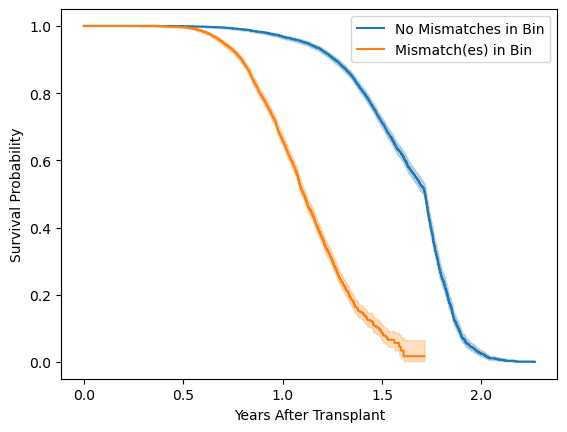

In [14]:
score_df(amino_acid_bin_scores, amino_acid_bins)
top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                           amino_acid_bin_scores)

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Best Bin: ['P_3', 'P_4', 'R_6', 'P_6', 'P_7', 'P_8']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 20,Bin 30,Bin 16,Bin 33,Bin 8,Bin 35,Bin 34,Bin 37,Bin 36,Bin 18
Score,222.211868,215.250537,164.061434,137.944529,134.999498,132.266824,130.180049,126.895277,122.916129,114.686057
Bins,"[P_3, P_4, R_6, P_6, P_7, P_8]","[R_13, P_2, P_4, P_7, P_1, P_10]","[P_2, P_4, P_6, R_33, P_5]","[P_6, P_4, R_12, P_2, P_5]","[P_6, P_8, P_5, R_20, P_1, P_10, P_3, R_26]","[P_1, P_2, P_5, R_13, P_6]","[P_3, R_15, P_7, P_1]","[P_3, R_29, P_7, P_4, P_1]","[P_4, P_7, P_1, R_1]","[P_3, P_6, P_5, R_10]"


Bin of Amino Acid Positions:
['P_3', 'P_4', 'R_6', 'P_6', 'P_7', 'P_8']
---
Number of Instances with No Mismatches in Bin:
7135
Number of Instances with Mismatch(es) in Bin:
2865
---
p-value from Log Rank Test:
2.9780333510124516e-50


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         222.21 <0.005    164.52

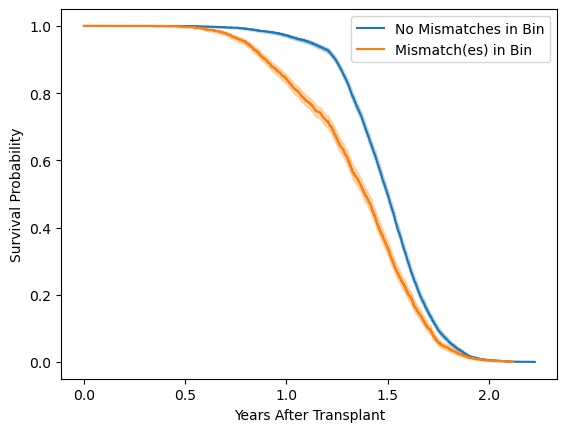

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Best Bin: ['R_37', 'P_3', 'P_2', 'P_8', 'P_7']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 12,Bin 11,Bin 24,Bin 14,Bin 8,Bin 20,Bin 9,Bin 22,Bin 26,Bin 7
Score,147.678736,143.125978,142.678922,109.85204,109.612317,108.881999,101.778995,95.76341,95.511567,86.274717
Bins,"[R_37, P_3, P_2, P_8, P_7]","[R_33, P_8, P_1, P_6]","[R_32, P_2, P_4, P_1, P_6]","[P_2, P_4, P_8, R_4]","[R_19, P_2, P_8, P_1, P_10]","[P_3, P_2, P_4, R_6, P_7, P_6, P_1, R_13, R_26]","[P_8, R_9, P_4, P_5]","[P_3, P_2, P_4, P_8, R_17, R_12, P_7]","[P_6, P_8, P_1, R_1]","[P_10, P_2, P_9, R_4, R_7, P_5]"


Bin of Amino Acid Positions:
['R_37', 'P_3', 'P_2', 'P_8', 'P_7']
---
Number of Instances with No Mismatches in Bin:
7333
Number of Instances with Mismatch(es) in Bin:
2667
---
p-value from Log Rank Test:
5.57645728604635e-34


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         147.68 <0.005    110.47

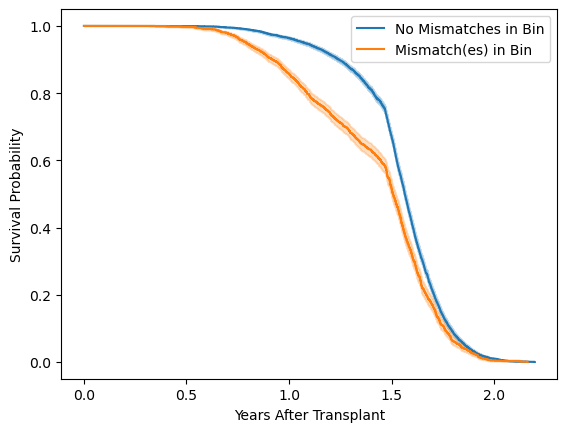

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Best Bin: ['P_3', 'P_6', 'P_4', 'P_10', 'R_12']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 38,Bin 40,Bin 22,Bin 32,Bin 9,Bin 29,Bin 28,Bin 25,Bin 12,Bin 21
Score,181.772692,142.837473,138.578756,125.501889,124.055353,123.999999,123.579638,123.215537,121.05731,118.207474
Bins,"[P_3, P_6, P_4, P_10, R_12]","[P_3, P_1, P_6, R_15, R_15]","[P_3, P_2, P_4, P_5, R_20, R_30]","[R_18, P_2, P_6, P_9]","[P_6, P_10, P_2, P_3, R_16, R_10]","[R_13, P_3, P_4, P_7]","[P_3, R_10, P_6]","[P_2, P_6, P_9, R_24]","[P_3, P_4, R_24, P_9]","[P_3, P_8, P_2, R_9]"


Bin of Amino Acid Positions:
['P_3', 'P_6', 'P_4', 'P_10', 'R_12']
---
Number of Instances with No Mismatches in Bin:
7246
Number of Instances with Mismatch(es) in Bin:
2754
---
p-value from Log Rank Test:
1.9878337383299308e-41


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         181.77 <0.005    135.21

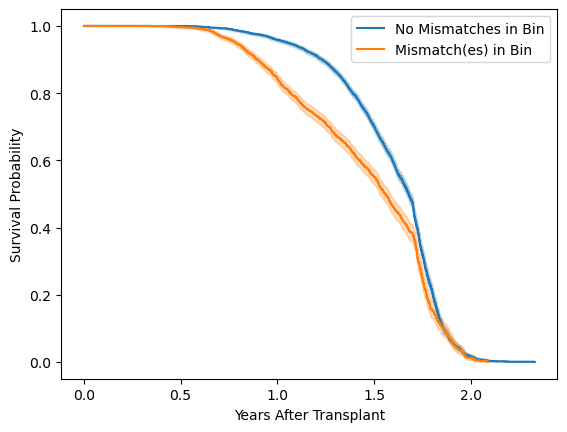

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['P_4', 'P_6', 'P_7', 'R_34', 'P_5', 'P_2']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 27,Bin 13,Bin 26,Bin 40,Bin 38,Bin 29,Bin 37,Bin 11,Bin 6,Bin 8
Score,204.655309,164.535259,156.919958,148.884838,127.633316,112.926399,111.986388,109.192523,105.777526,102.451535
Bins,"[P_4, P_6, P_7, R_34, P_5, P_2]","[P_7, P_9, P_6, P_5, R_38]","[P_10, P_6, P_1, P_5, R_29]","[P_9, P_8, P_5, P_10, R_12]","[P_8, P_10, R_3, P_4, P_1]","[P_2, P_6, P_9, P_7, R_38, R_6, P_3]","[P_7, P_9, P_2, R_6]","[P_6, P_7, P_10, R_9, P_4]","[R_6, P_6, P_7, P_5]","[R_25, P_9, P_10, P_5]"


Bin of Amino Acid Positions:
['P_4', 'P_6', 'P_7', 'R_34', 'P_5', 'P_2']
---
Number of Instances with No Mismatches in Bin:
7164
Number of Instances with Mismatch(es) in Bin:
2836
---
p-value from Log Rank Test:
2.013706536219185e-46


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         204.66 <0.005    151.80

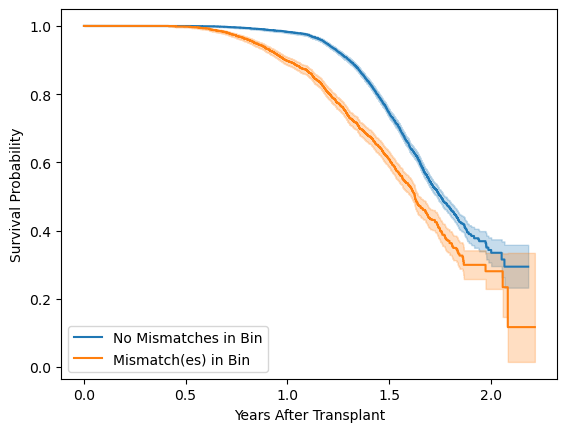

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Best Bin: ['P_3', 'R_33', 'P_7', 'P_6', 'P_5']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 11,Bin 27,Bin 29,Bin 36,Bin 18,Bin 35,Bin 22,Bin 28,Bin 1,Bin 16
Score,195.101984,171.051583,138.293112,114.738478,111.04032,107.798112,105.607421,97.847707,95.943909,93.592144
Bins,"[P_3, R_33, P_7, P_6, P_5]","[R_26, P_3, P_4, P_6, P_10]","[P_4, P_8, R_9, P_5, P_3]","[P_4, P_8, P_5, P_7, R_7]","[R_21, P_2, P_6, P_5]","[P_2, P_7, R_9, P_10, P_4]","[P_6, P_9, P_1, R_7, P_7]","[P_2, P_7, R_36, P_5, P_10, R_34, P_6]","[P_5, P_10, R_36, P_6]","[P_4, P_6, P_7, R_5]"


Bin of Amino Acid Positions:
['P_3', 'R_33', 'P_7', 'P_6', 'P_5']
---
Number of Instances with No Mismatches in Bin:
7202
Number of Instances with Mismatch(es) in Bin:
2798
---
p-value from Log Rank Test:
2.4476732848834745e-44


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         195.10 <0.005    144.87

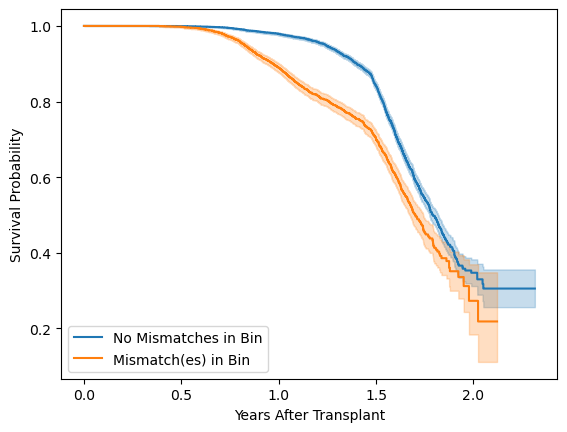

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Best Bin: ['P_3', 'P_4', 'P_9', 'P_1', 'R_34', 'P_8']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 6,Bin 25,Bin 24,Bin 15,Bin 31,Bin 32,Bin 14,Bin 4,Bin 35,Bin 11
Score,279.916487,189.323378,167.068712,144.07154,139.956977,125.178872,122.88658,121.94362,118.454865,105.78781
Bins,"[P_3, P_4, P_9, P_1, R_34, P_8]","[P_9, P_5, P_10, P_2, R_7]","[P_3, P_7, P_4, R_5, P_8]","[P_6, P_10, P_1, R_26]","[P_4, R_26, P_5, P_3]","[P_3, P_5, P_10, R_1]","[P_3, P_2, P_1, R_38]","[P_6, R_4, P_1, P_4]","[R_6, P_4, P_9, P_1]","[P_4, R_6, P_7, P_9, P_1, P_10, R_19]"


Bin of Amino Acid Positions:
['P_3', 'P_4', 'P_9', 'P_1', 'R_34', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5893
Number of Instances with Mismatch(es) in Bin:
4107
---
p-value from Log Rank Test:
7.830600592906773e-63


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         279.92 <0.005    206.31

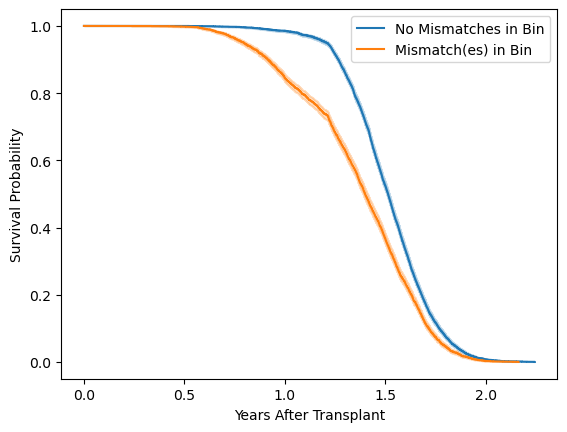

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['P_2', 'P_7', 'P_9', 'P_10', 'R_13', 'R_13']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 20,Bin 31,Bin 13,Bin 9,Bin 40,Bin 7,Bin 4,Bin 38,Bin 8,Bin 34
Score,243.112306,205.125377,203.993027,192.73502,189.167617,184.038359,172.656873,172.501863,167.876243,147.99263
Bins,"[P_2, P_7, P_9, P_10, R_13, R_13]","[P_2, R_11, P_1, P_10, P_9]","[P_2, P_4, P_7, P_8, R_32]","[R_11, P_7, P_2, P_10, P_5]","[P_2, P_9, P_8, P_1, P_10, R_14]","[P_2, P_7, P_9, R_11, P_5]","[R_26, P_9, P_10, P_7, P_6]","[P_10, P_9, P_8, P_5, P_7, R_37]","[P_6, P_2, P_10, R_30]","[P_1, P_9, P_7, P_2, R_5]"


Bin of Amino Acid Positions:
['P_2', 'P_7', 'P_9', 'P_10', 'R_13', 'R_13']
---
Number of Instances with No Mismatches in Bin:
6036
Number of Instances with Mismatch(es) in Bin:
3964
---
p-value from Log Rank Test:
8.243311206763719e-55


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         243.11 <0.005    179.66

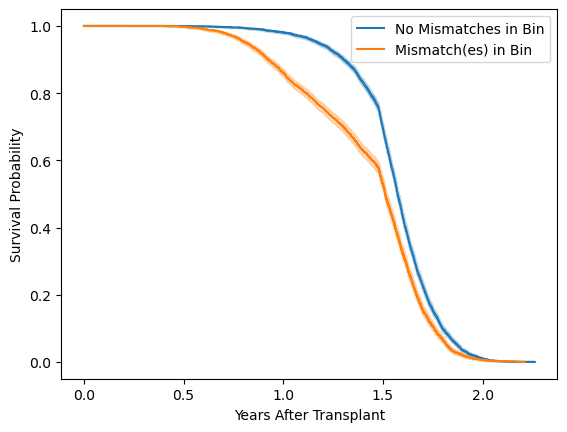

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Best Bin: ['P_3', 'P_8', 'P_6', 'P_1', 'P_10', 'R_12', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 39,Bin 28,Bin 25,Bin 8,Bin 40,Bin 15,Bin 27,Bin 30,Bin 5,Bin 2
Score,350.860934,329.93427,299.123639,230.87698,226.165744,222.31563,217.445592,209.210348,203.005255,187.661294
Bins,"[P_3, P_8, P_6, P_1, P_10, R_12, P_9]","[P_3, P_5, R_34, P_7, P_4, P_2]","[P_3, P_1, P_4, P_6, P_10, R_35]","[P_1, P_3, P_9, R_3, P_8]","[P_3, P_1, P_4, P_10, R_35]","[P_1, P_6, P_10, R_11, P_8]","[P_6, R_3, P_10, P_4, P_1]","[P_7, P_1, P_10, R_34]","[R_19, P_2, P_9, P_5, P_7]","[P_1, R_34, P_10, P_4, P_4]"


Bin of Amino Acid Positions:
['P_3', 'P_8', 'P_6', 'P_1', 'P_10', 'R_12', 'P_9']
---
Number of Instances with No Mismatches in Bin:
5834
Number of Instances with Mismatch(es) in Bin:
4166
---
p-value from Log Rank Test:
2.7520706779532213e-78


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         350.86 <0.005    257.65

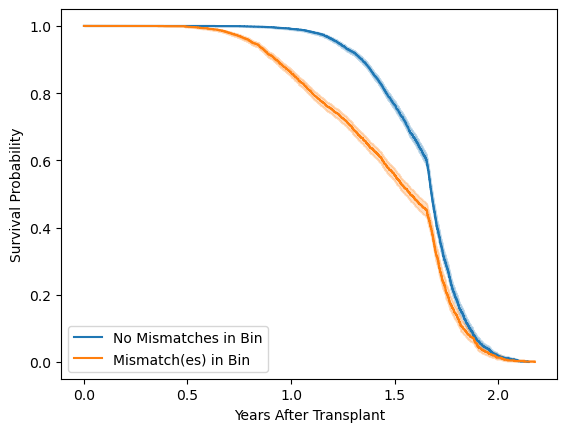

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['P_3', 'P_6', 'P_9', 'P_8', 'P_5', 'R_38']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 36,Bin 16,Bin 27,Bin 32,Bin 30,Bin 17,Bin 20,Bin 31,Bin 21,Bin 13
Score,179.812824,176.326944,175.27844,162.113384,145.483459,143.151547,134.332743,128.630818,123.258477,122.930124
Bins,"[P_3, P_6, P_9, P_8, P_5, R_38]","[P_2, P_6, P_8, P_10, P_5, R_8]","[P_9, R_2, P_5, P_1, P_6]","[P_6, P_9, P_8, R_28, P_10]","[P_3, P_6, P_9, P_5, R_30]","[P_2, P_9, P_5, P_6, R_3]","[P_2, P_6, P_8, R_28, P_10, P_9, P_7, R_24]","[P_3, P_6, P_8, R_26]","[P_7, P_9, P_6, R_28]","[P_2, P_5, R_2, P_1]"


Bin of Amino Acid Positions:
['P_3', 'P_6', 'P_9', 'P_8', 'P_5', 'R_38']
---
Number of Instances with No Mismatches in Bin:
5907
Number of Instances with Mismatch(es) in Bin:
4093
---
p-value from Log Rank Test:
5.324619987155144e-41


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         179.81 <0.005    133.79

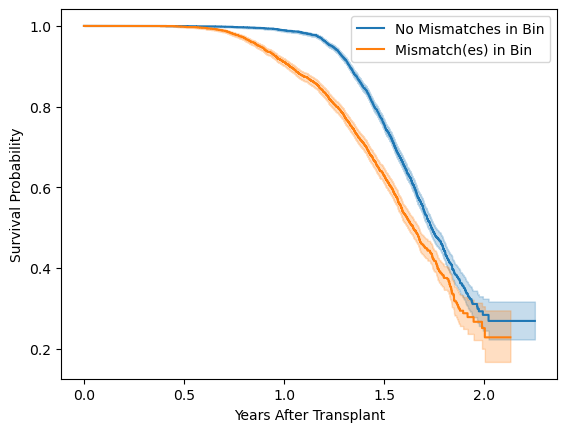

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Best Bin: ['R_27', 'P_4', 'P_6', 'P_9', 'P_8', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 15,Bin 32,Bin 37,Bin 27,Bin 22,Bin 21,Bin 10,Bin 25,Bin 38
Score,231.685242,192.020244,187.675559,175.590784,161.491119,155.964935,148.332885,147.471948,145.2107,132.472623
Bins,"[R_27, P_4, P_6, P_9, P_8, P_3]","[P_3, P_8, P_5, P_1, R_21, R_21]","[R_21, P_10, P_8, P_1, P_4]","[R_37, P_8, P_7, P_2]","[P_4, P_7, P_1, P_10, R_24]","[R_32, P_4, P_8, P_5, P_1]","[P_4, P_9, R_26, P_10]","[P_6, P_1, P_9, R_30, P_5]","[P_3, P_9, P_8, R_28, P_5]","[P_6, P_8, P_10, R_18]"


Bin of Amino Acid Positions:
['R_27', 'P_4', 'P_6', 'P_9', 'P_8', 'P_3']
---
Number of Instances with No Mismatches in Bin:
5937
Number of Instances with Mismatch(es) in Bin:
4063
---
p-value from Log Rank Test:
2.5575563883870316e-52


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         231.69 <0.005    171.39

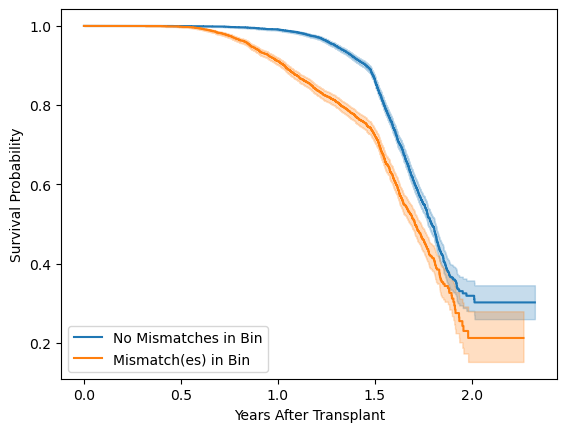

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Best Bin: ['P_3', 'P_4', 'P_8', 'R_10', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 10,Bin 12,Bin 32,Bin 1,Bin 19,Bin 33,Bin 30,Bin 21,Bin 25,Bin 13
Score,208.520207,192.965522,182.738832,165.603039,154.238392,144.183805,138.166552,132.364756,127.966639,126.220093
Bins,"[P_3, P_4, P_8, R_10, P_6]","[P_4, P_6, P_5, P_1, P_2, R_23, P_8]","[P_4, P_7, P_1, R_7, P_8]","[P_1, P_4, P_5, R_10]","[R_15, P_2, P_4, P_8, P_7]","[P_5, P_2, P_4, R_1]","[P_1, P_2, P_4, R_30]","[P_7, P_2, P_4, R_25]","[P_6, P_9, P_5, R_37]","[P_3, R_8, P_4, P_9]"


Bin of Amino Acid Positions:
['P_3', 'P_4', 'P_8', 'R_10', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5074
Number of Instances with Mismatch(es) in Bin:
4926
---
p-value from Log Rank Test:
2.888817359901693e-47


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         208.52 <0.005    154.60

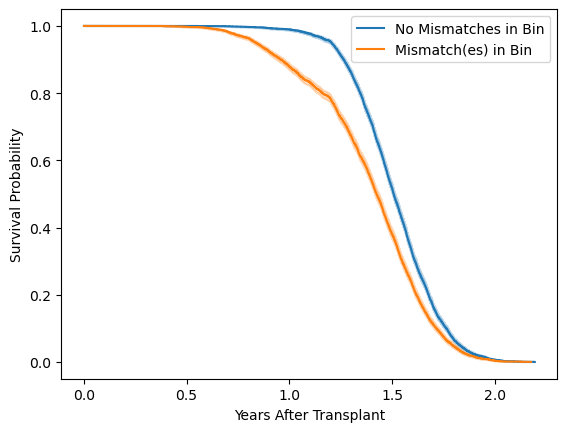

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Best Bin: ['P_2', 'P_9', 'P_8', 'P_5', 'R_7']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 25,Bin 3,Bin 33,Bin 13,Bin 8,Bin 43,Bin 23,Bin 37,Bin 12
Score,179.921688,177.287893,145.988268,144.934573,142.254066,140.663195,139.932458,130.341273,129.202485,127.902425
Bins,"[P_2, P_9, P_8, P_5, R_7]","[P_6, R_6, P_7, P_3]","[P_3, P_6, R_18, P_9]","[P_6, P_5, R_37, P_9]","[P_7, P_5, R_38, P_8]","[P_10, P_2, P_9, R_7]","[P_9, P_8, P_2, R_25, P_7]","[P_2, P_6, P_8, R_7]","[P_8, P_5, P_10, R_10]","[R_21, P_3, P_2, P_9, P_10]"


Bin of Amino Acid Positions:
['P_2', 'P_9', 'P_8', 'P_5', 'R_7']
---
Number of Instances with No Mismatches in Bin:
5057
Number of Instances with Mismatch(es) in Bin:
4943
---
p-value from Log Rank Test:
5.041026315955286e-41


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         179.92 <0.005    133.87

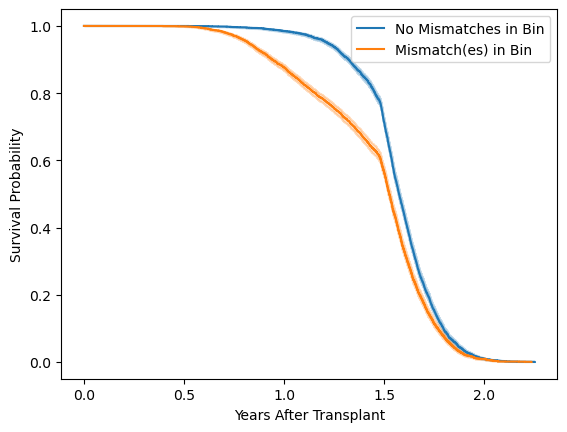

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Best Bin: ['P_2', 'P_4', 'P_1', 'R_26', 'P_5', 'P_3', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 32,Bin 13,Bin 35,Bin 40,Bin 30,Bin 23,Bin 26,Bin 10,Bin 37,Bin 19
Score,242.1678,240.826821,231.283013,230.02213,225.097275,209.58682,208.864842,196.070033,190.581062,187.31878
Bins,"[P_2, P_4, P_1, R_26, P_5, P_3, P_6]","[P_7, R_19, P_5, P_8, P_2]","[P_7, P_6, P_5, R_19, P_1]","[P_3, P_7, P_5, P_1, R_15]","[P_7, P_6, R_36, P_1, P_8]","[P_10, R_25, P_7, P_5, P_6]","[P_8, P_1, R_24, P_2, P_7]","[P_8, P_10, P_7, R_38]","[P_4, P_5, P_3, R_38]","[P_2, P_7, P_6, R_12]"


Bin of Amino Acid Positions:
['P_2', 'P_4', 'P_1', 'R_26', 'P_5', 'P_3', 'P_6']
---
Number of Instances with No Mismatches in Bin:
4915
Number of Instances with Mismatch(es) in Bin:
5085
---
p-value from Log Rank Test:
1.3244544310695498e-54


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         242.17 <0.005    178.98

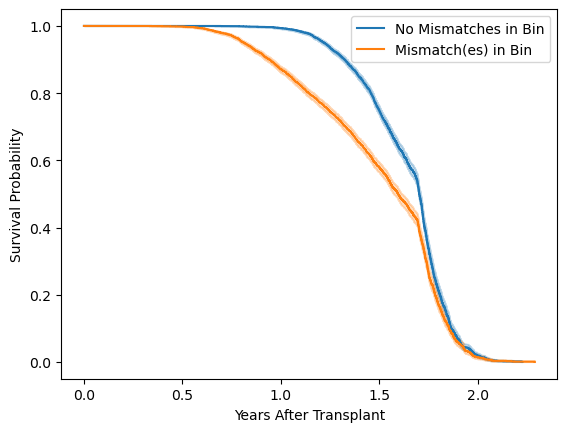

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


Best Bin: ['P_4', 'R_2', 'P_5', 'P_1', 'P_9', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 9,Bin 19,Bin 12,Bin 36,Bin 21,Bin 33,Bin 31,Bin 10,Bin 22,Bin 23
Score,233.71775,231.877373,192.958037,190.565105,188.919784,187.126927,174.639234,174.203107,169.435995,164.032335
Bins,"[P_4, R_2, P_5, P_1, P_9, P_6]","[P_3, P_6, P_7, P_5, R_18]","[R_15, P_7, P_9, P_6, P_10]","[P_4, P_8, P_5, P_1, P_10, R_23]","[P_3, P_4, P_5, R_6]","[P_4, R_6, P_7, P_1]","[P_3, P_7, P_5, R_18]","[R_32, P_4, P_9, P_5, P_1]","[P_4, P_1, R_14, P_2]","[P_8, P_10, P_1, R_14]"


Bin of Amino Acid Positions:
['P_4', 'R_2', 'P_5', 'P_1', 'P_9', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5039
Number of Instances with Mismatch(es) in Bin:
4961
---
p-value from Log Rank Test:
9.21702881272225e-53


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         233.72 <0.005    172.86

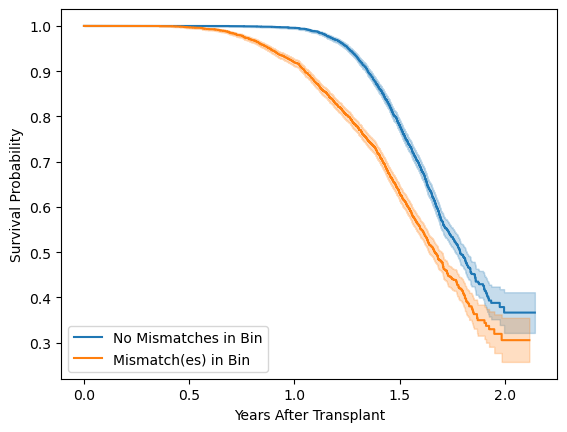

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Best Bin: ['P_2', 'P_7', 'P_9', 'P_8', 'P_10', 'P_3', 'R_10']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 21,Bin 36,Bin 29,Bin 17,Bin 8,Bin 5,Bin 16,Bin 39,Bin 32,Bin 22
Score,157.040415,146.84058,128.116007,126.119001,124.813926,123.816597,122.117015,122.108247,120.206344,119.856772
Bins,"[P_2, P_7, P_9, P_8, P_10, P_3, R_10]","[P_3, P_9, R_9, P_10, P_2, P_6]","[P_4, P_7, P_9, R_18]","[P_2, P_6, R_14, P_5]","[R_21, P_2, P_9, P_8, P_10, P_6]","[P_6, P_9, R_11, P_10]","[P_4, P_7, P_9, P_10, R_15, P_5]","[P_4, P_7, P_9, P_6, R_29]","[P_9, P_7, R_14, P_6]","[P_10, R_5, P_5, P_9, P_6]"


Bin of Amino Acid Positions:
['P_2', 'P_7', 'P_9', 'P_8', 'P_10', 'P_3', 'R_10']
---
Number of Instances with No Mismatches in Bin:
4925
Number of Instances with Mismatch(es) in Bin:
5075
---
p-value from Log Rank Test:
5.015551075203723e-36


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         157.04 <0.005    117.26

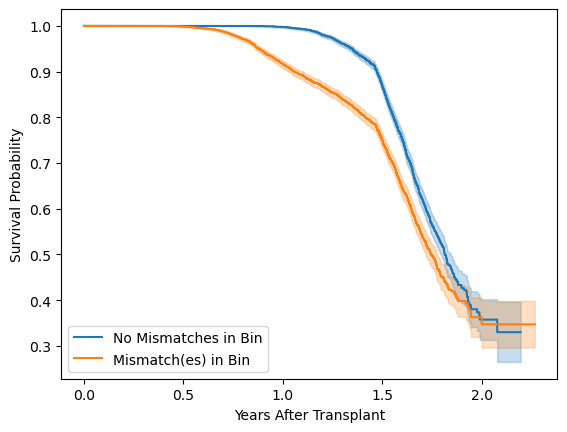

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Best Bin: ['P_3', 'P_6', 'R_28', 'P_7', 'P_10']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 15,Bin 13,Bin 14,Bin 5,Bin 4,Bin 45,Bin 25,Bin 35,Bin 7,Bin 11
Score,164.971974,126.759161,125.699288,117.869954,111.76994,108.859694,107.004494,105.861594,101.56609,100.51511
Bins,"[P_3, P_6, R_28, P_7, P_10]","[P_3, R_38, P_4, P_5]","[P_3, P_5, R_38, P_1]","[P_7, P_4, P_10, R_8]","[P_2, P_4, R_40, P_8, P_10]","[P_8, P_6, P_3, R_2]","[R_21, P_3, P_6, P_1]","[P_3, P_4, R_32, P_8]","[P_3, P_2, P_10, R_13]","[P_3, P_2, P_10, R_19]"


Bin of Amino Acid Positions:
['P_3', 'P_6', 'R_28', 'P_7', 'P_10']
---
Number of Instances with No Mismatches in Bin:
4142
Number of Instances with Mismatch(es) in Bin:
5858
---
p-value from Log Rank Test:
9.277526958007022e-38


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         164.97 <0.005    123.02

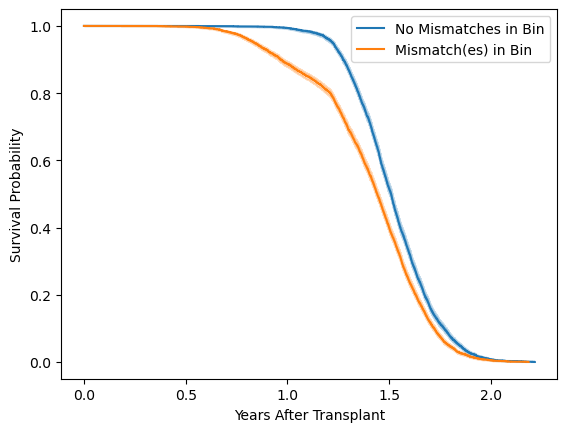

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Best Bin: ['R_21', 'P_9', 'P_5', 'P_4']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 3,Bin 13,Bin 29,Bin 11,Bin 18,Bin 21,Bin 8,Bin 27,Bin 36,Bin 16
Score,170.781366,165.079018,158.610104,148.834731,136.625496,133.865643,131.913739,131.517039,128.659455,127.68683
Bins,"[R_21, P_9, P_5, P_4]","[P_1, P_8, P_4, R_21]","[P_4, R_16, P_8, P_5, P_1, P_6]","[P_8, P_6, P_7, R_6]","[P_1, P_4, R_33, P_6]","[P_4, P_5, P_1, R_1, P_9]","[P_1, P_5, P_4, R_1, P_10]","[P_1, R_2, P_2, P_5]","[P_3, P_8, P_5, P_4, P_9, R_26]","[P_8, P_5, R_33, P_6]"


Bin of Amino Acid Positions:
['R_21', 'P_9', 'P_5', 'P_4']
---
Number of Instances with No Mismatches in Bin:
4218
Number of Instances with Mismatch(es) in Bin:
5782
---
p-value from Log Rank Test:
4.994712804576059e-39


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         170.78 <0.005    127.23

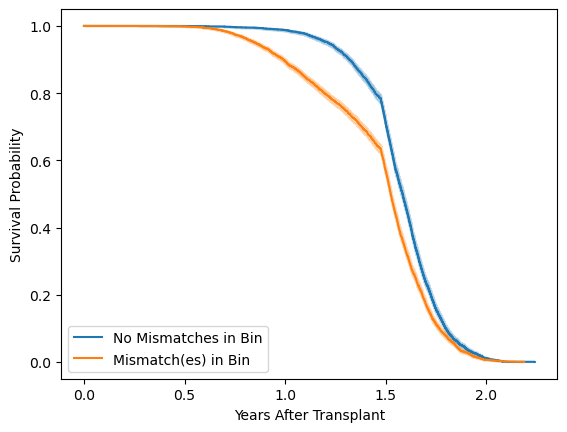

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Best Bin: ['P_3', 'P_2', 'P_4', 'P_5', 'P_1', 'R_38', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 38,Bin 34,Bin 14,Bin 21,Bin 10,Bin 16,Bin 28,Bin 20,Bin 2,Bin 26
Score,220.020609,189.470108,172.645226,165.457625,147.563088,135.17041,133.669254,132.536515,126.433952,126.433952
Bins,"[P_3, P_2, P_4, P_5, P_1, R_38, P_6]","[P_3, P_7, P_9, R_23, P_6]","[R_25, P_4, P_6, P_8, P_1]","[P_7, P_10, R_36, P_6]","[P_5, R_22, P_4, P_2]","[P_4, P_6, P_1, R_18]","[P_2, R_22, P_8, P_6]","[P_4, P_10, R_38]","[P_7, P_10, R_23]","[P_7, R_23, P_10]"


Bin of Amino Acid Positions:
['P_3', 'P_2', 'P_4', 'P_5', 'P_1', 'R_38', 'P_6']
---
Number of Instances with No Mismatches in Bin:
4051
Number of Instances with Mismatch(es) in Bin:
5949
---
p-value from Log Rank Test:
8.951343178192722e-50


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         220.02 <0.005    162.93

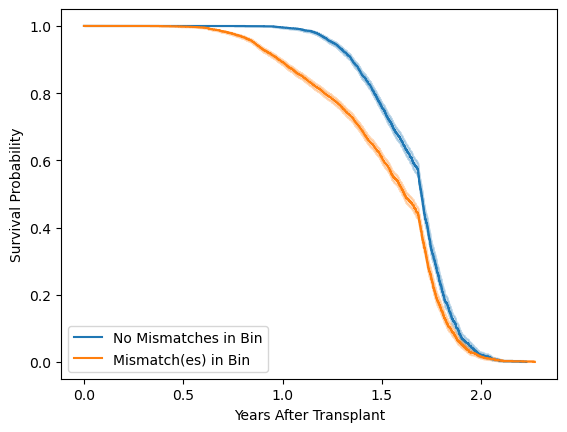

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Best Bin: ['P_3', 'R_27', 'P_5', 'P_9', 'P_4']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 4,Bin 33,Bin 9,Bin 38,Bin 23,Bin 25,Bin 26,Bin 27,Bin 1,Bin 32
Score,181.102261,177.333757,160.991332,151.905903,149.282078,140.880276,136.657503,134.537893,133.083865,131.304556
Bins,"[P_3, R_27, P_5, P_9, P_4]","[P_3, P_8, P_5, R_30, P_10, P_2]","[R_27, P_4, P_5, P_1]","[P_2, P_4, P_1, P_10, R_16]","[P_3, P_4, P_1, P_10, R_34, P_5]","[P_3, P_1, P_10, R_24]","[P_3, P_7, P_8, R_9]","[P_10, P_5, R_25, P_3, P_1]","[P_7, R_27, P_5]","[P_3, P_8, R_24, P_5]"


Bin of Amino Acid Positions:
['P_3', 'R_27', 'P_5', 'P_9', 'P_4']
---
Number of Instances with No Mismatches in Bin:
4086
Number of Instances with Mismatch(es) in Bin:
5914
---
p-value from Log Rank Test:
2.7845561813659306e-41


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         181.10 <0.005    134.72

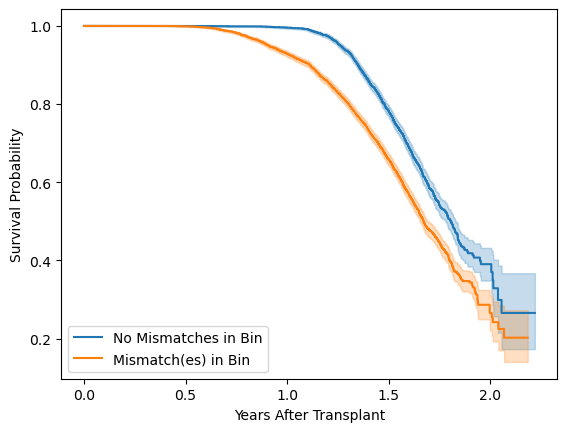

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Best Bin: ['P_1', 'P_7', 'R_28', 'P_2', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 13,Bin 5,Bin 36,Bin 26,Bin 27,Bin 35,Bin 6,Bin 14,Bin 21,Bin 38
Score,109.757592,94.722623,92.614148,88.553992,86.821927,86.591397,86.5094,83.083195,81.288182,79.401345
Bins,"[P_1, P_7, R_28, P_2, P_9]","[P_1, P_7, R_28, P_10]","[R_16, P_1, P_4, P_10]","[P_7, P_10, P_4, R_25]","[P_7, P_8, P_5, R_27, P_3]","[P_4, P_7, P_10, R_39]","[P_9, R_36, P_4, P_10]","[R_36, P_10, P_4, P_5]","[P_2, P_8, R_18, P_5]","[P_2, P_4, P_7, R_35]"


Bin of Amino Acid Positions:
['P_1', 'P_7', 'R_28', 'P_2', 'P_9']
---
Number of Instances with No Mismatches in Bin:
4093
Number of Instances with Mismatch(es) in Bin:
5907
---
p-value from Log Rank Test:
1.107372878795114e-25


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         109.76 <0.005     82.90

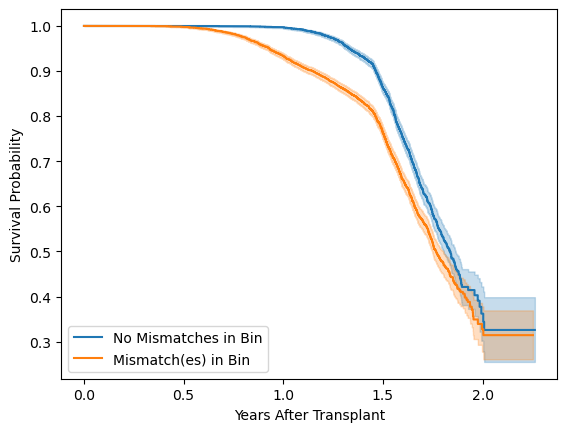

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Best Bin: ['P_3', 'P_10', 'R_2', 'P_7']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 11,Bin 36,Bin 40,Bin 24,Bin 23,Bin 22,Bin 2,Bin 39,Bin 20
Score,117.383544,115.092579,110.322889,102.615533,93.965141,91.836335,90.446178,89.98519,88.868337,87.707214
Bins,"[P_3, P_10, R_2, P_7]","[P_7, R_38, P_3, P_10]","[R_23, P_4, P_6, P_2]","[P_6, P_8, P_7, R_9]","[P_3, P_2, P_6, P_9, R_10]","[P_6, R_2, P_4]","[P_7, P_8, P_5, R_33, P_8]","[P_3, P_8, R_23]","[R_25, P_4, P_5, P_7, P_3]","[P_6, P_2, R_23]"


Bin of Amino Acid Positions:
['P_3', 'P_10', 'R_2', 'P_7']
---
Number of Instances with No Mismatches in Bin:
3400
Number of Instances with Mismatch(es) in Bin:
6600
---
p-value from Log Rank Test:
2.3659173127197866e-27


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         117.38 <0.005     88.45

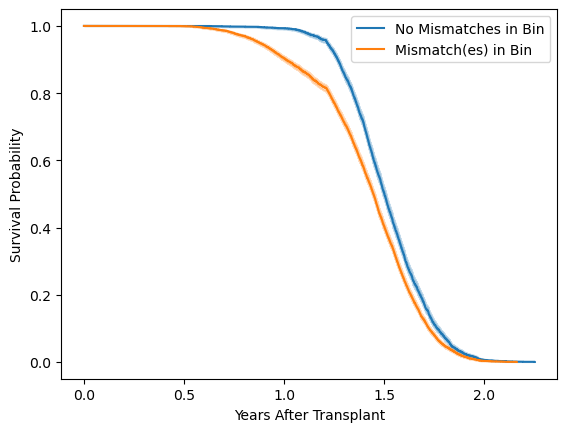

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Best Bin: ['P_4', 'P_7', 'P_6', 'R_5', 'P_2']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 20,Bin 26,Bin 27,Bin 35,Bin 1,Bin 5,Bin 14,Bin 9,Bin 37,Bin 8
Score,97.18223,93.266748,91.884433,89.251742,89.088116,83.32349,83.188767,76.779185,76.123845,76.066601
Bins,"[P_4, P_7, P_6, R_5, P_2]","[P_6, P_9, P_1, P_4, R_10]","[P_3, P_4, R_14, P_10]","[P_4, P_6, P_5, R_24]","[P_1, R_33, P_5, P_9]","[P_1, R_29, P_10]","[P_4, P_9, P_6, R_20]","[P_7, P_1, P_6, R_27, P_4]","[R_27, P_2, P_4, P_6, P_8]","[P_4, R_19, P_1]"


Bin of Amino Acid Positions:
['P_4', 'P_7', 'P_6', 'R_5', 'P_2']
---
Number of Instances with No Mismatches in Bin:
3337
Number of Instances with Mismatch(es) in Bin:
6663
---
p-value from Log Rank Test:
6.323158768146148e-23


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          97.18 <0.005     73.74

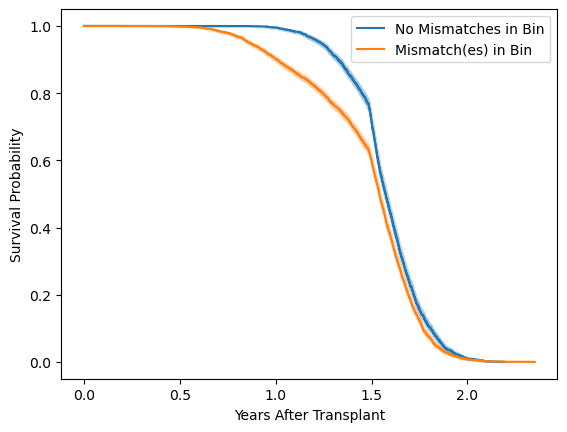

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Best Bin: ['P_5', 'P_10', 'P_2', 'R_28']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 6,Bin 32,Bin 7,Bin 26,Bin 2,Bin 16,Bin 25,Bin 13,Bin 12,Bin 35
Score,141.936915,119.739243,115.101493,113.339739,109.856071,109.304115,103.720718,102.712884,102.38891,102.38891
Bins,"[P_5, P_10, P_2, R_28]","[R_13, P_4, P_6, P_8]","[P_7, P_4, R_28]","[P_1, P_5, R_11, P_3]","[P_3, P_9, R_9, P_4, P_5]","[P_1, R_27, P_4, P_8]","[P_1, P_9, R_22]","[P_1, P_4, P_9, R_24]","[P_3, P_8, R_15, P_4]","[P_3, P_4, P_8, R_15]"


Bin of Amino Acid Positions:
['P_5', 'P_10', 'P_2', 'R_28']
---
Number of Instances with No Mismatches in Bin:
3353
Number of Instances with Mismatch(es) in Bin:
6647
---
p-value from Log Rank Test:
1.0038647154224779e-32


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         141.94 <0.005    106.30

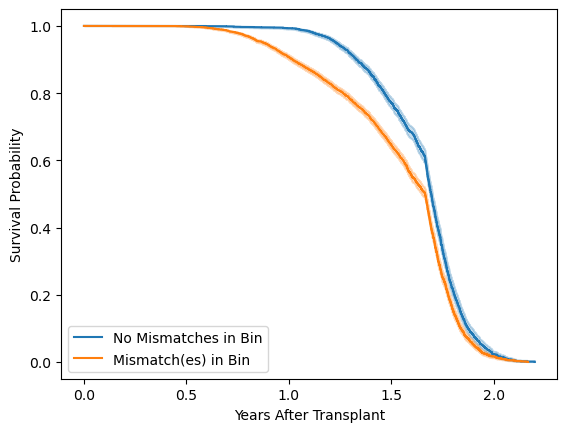

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Best Bin: ['P_3', 'P_2', 'P_5', 'R_40']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 23,Bin 19,Bin 14,Bin 12,Bin 4,Bin 26,Bin 17,Bin 38,Bin 15,Bin 29
Score,120.082971,94.160633,91.983086,88.733156,80.082987,75.1167,72.467684,69.827365,69.377092,68.564589
Bins,"[P_3, P_2, P_5, R_40]","[P_6, P_2, P_10, R_1]","[P_3, P_9, R_39, P_5, P_10]","[P_9, R_39, P_5, P_10, P_1]","[P_10, P_6, P_4, R_19, P_1]","[P_2, R_1, P_6]","[P_3, R_34, P_5]","[P_4, P_1, R_13]","[P_6, R_39, P_2]","[P_4, P_10, P_5, R_35]"


Bin of Amino Acid Positions:
['P_3', 'P_2', 'P_5', 'R_40']
---
Number of Instances with No Mismatches in Bin:
3421
Number of Instances with Mismatch(es) in Bin:
6579
---
p-value from Log Rank Test:
6.066933855753772e-28


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         120.08 <0.005     90.41

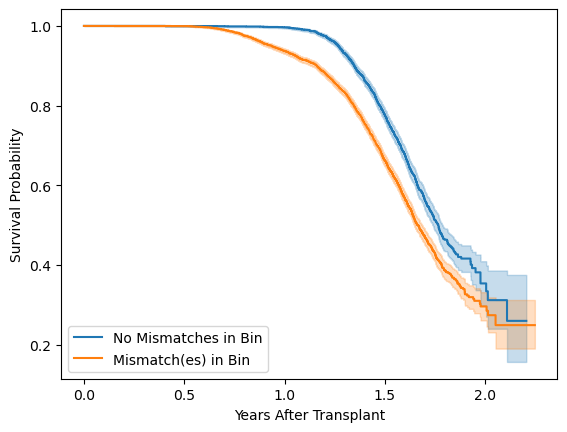

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Best Bin: ['R_28', 'P_10', 'P_5', 'P_2']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 1,Bin 26,Bin 37,Bin 25,Bin 21,Bin 12,Bin 23,Bin 28,Bin 24,Bin 14
Score,98.566065,96.328229,91.196009,87.500629,85.166903,84.456165,83.422496,83.089798,80.183076,77.201114
Bins,"[R_28, P_10, P_5, P_2]","[P_7, P_10, P_4, R_28]","[R_25, P_4, P_9, P_8, P_5, P_6]","[P_3, P_9, P_7, R_7]","[R_5, P_7, P_5]","[P_3, R_7, P_8, P_2]","[P_7, P_9, P_8, R_6]","[R_5, P_7, P_6]","[R_25, P_4, P_9, P_10]","[P_7, R_27, P_10, P_2]"


Bin of Amino Acid Positions:
['R_28', 'P_10', 'P_5', 'P_2']
---
Number of Instances with No Mismatches in Bin:
3416
Number of Instances with Mismatch(es) in Bin:
6584
---
p-value from Log Rank Test:
3.1436025552262867e-23


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          98.57 <0.005     74.75

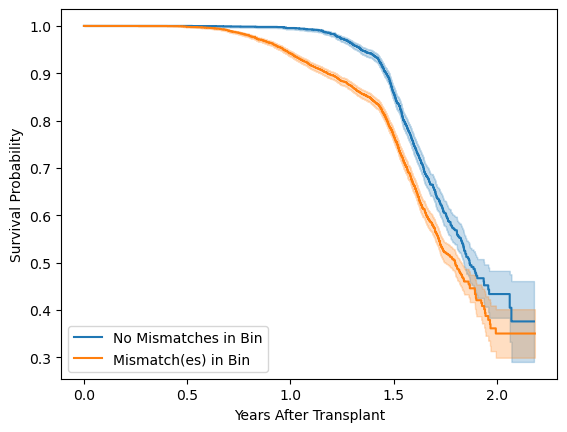

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Best Bin: ['P_6', 'R_34', 'P_1']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 11,Bin 7,Bin 39,Bin 27,Bin 21,Bin 12,Bin 3,Bin 37,Bin 33,Bin 26
Score,81.952534,81.012678,77.379646,76.760564,76.019435,73.029353,72.446004,70.084204,69.578167,66.481524
Bins,"[P_6, R_34, P_1]","[R_34, P_7, P_1]","[P_3, P_10, P_4, R_19, P_7]","[P_8, R_6, P_6, P_1]","[P_2, P_6, P_10, R_23]","[R_10, P_8, P_4]","[P_1, R_10, P_2]","[R_10, P_10, P_6]","[P_6, P_10, P_3, R_27]","[P_3, P_1, R_17, P_10]"


Bin of Amino Acid Positions:
['P_6', 'R_34', 'P_1']
---
Number of Instances with No Mismatches in Bin:
2519
Number of Instances with Mismatch(es) in Bin:
7481
---
p-value from Log Rank Test:
1.393944925817523e-19


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          81.95 <0.005     62.64

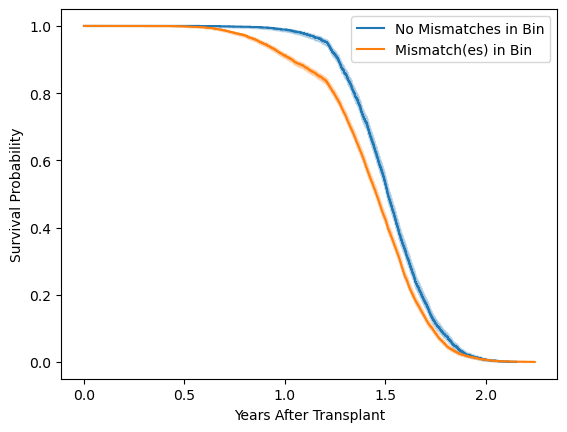

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Best Bin: ['P_3', 'P_7', 'R_4', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 13,Bin 20,Bin 21,Bin 5,Bin 30,Bin 15,Bin 39,Bin 8,Bin 9,Bin 25
Score,80.941253,76.730856,75.707561,73.616902,69.350266,68.519697,68.37049,68.14185,67.9073,67.297656
Bins,"[P_3, P_7, R_4, P_9]","[P_3, P_2, P_4, R_19]","[P_3, P_9, P_4, R_19]","[P_9, R_4, P_7]","[R_4, P_4, P_5]","[P_7, P_4, R_15]","[P_10, R_4, P_4]","[P_6, P_1, R_19]","[P_6, R_32, P_8]","[P_2, P_4, P_6, P_7, P_1, P_3, R_39]"


Bin of Amino Acid Positions:
['P_3', 'P_7', 'R_4', 'P_9']
---
Number of Instances with No Mismatches in Bin:
2543
Number of Instances with Mismatch(es) in Bin:
7457
---
p-value from Log Rank Test:
2.3252847907841166e-19


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          80.94 <0.005     61.90

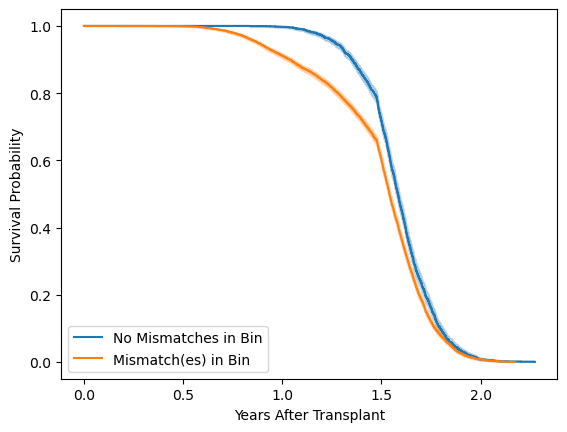

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Best Bin: ['R_33', 'P_5', 'P_2', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 31,Bin 21,Bin 34,Bin 3,Bin 12,Bin 18,Bin 37,Bin 13,Bin 30,Bin 24
Score,104.86329,100.464561,99.923589,99.346531,97.940851,90.296199,90.233506,89.321146,88.825074,87.981444
Bins,"[R_33, P_5, P_2, P_9]","[P_9, R_13, P_7]","[P_3, P_2, P_7, P_9, P_6, R_5]","[P_9, P_10, P_1, P_6, R_5]","[R_33, P_2, P_7, P_10]","[R_33, P_5, P_9]","[P_5, P_7, R_33]","[P_7, P_9, R_37, P_10, P_2]","[R_33, P_4, P_5]","[R_33, P_4, P_7]"


Bin of Amino Acid Positions:
['R_33', 'P_5', 'P_2', 'P_9']
---
Number of Instances with No Mismatches in Bin:
2471
Number of Instances with Mismatch(es) in Bin:
7529
---
p-value from Log Rank Test:
1.3086005272721155e-24


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         104.86 <0.005     79.34

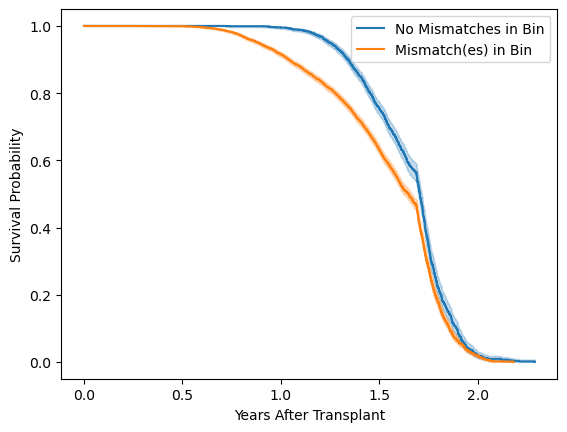

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


Best Bin: ['P_1', 'R_11', 'P_3', 'P_10']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 35,Bin 31,Bin 10,Bin 17,Bin 12,Bin 11,Bin 27,Bin 37,Bin 9,Bin 13
Score,70.371677,67.114708,65.355465,59.55127,58.895557,58.763707,58.685445,58.609972,57.413907,53.282109
Bins,"[P_1, R_11, P_3, P_10]","[P_1, R_11, P_2, P_9]","[P_3, P_2, P_10, R_40]","[R_40, P_10, P_9]","[P_8, P_6, R_21]","[P_1, P_2, R_11]","[P_1, P_2, R_3, P_9]","[P_2, P_4, R_30, P_1]","[P_1, P_4, R_11]","[P_1, P_4, R_26, P_2]"


Bin of Amino Acid Positions:
['P_1', 'R_11', 'P_3', 'P_10']
---
Number of Instances with No Mismatches in Bin:
2460
Number of Instances with Mismatch(es) in Bin:
7540
---
p-value from Log Rank Test:
4.912011158797427e-17


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          70.37 <0.005     54.18

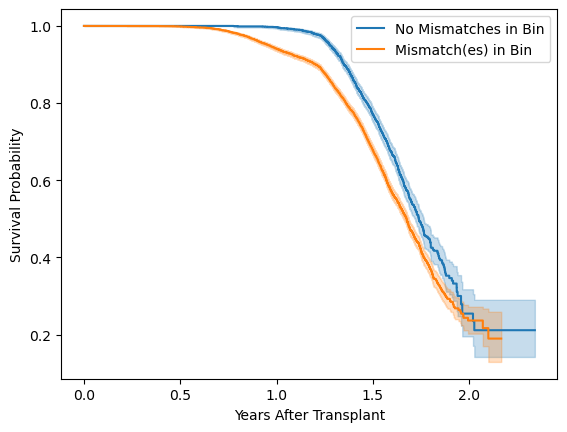

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Best Bin: ['P_3', 'R_15', 'P_4', 'P_10']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 35,Bin 39,Bin 31,Bin 8,Bin 7,Bin 11,Bin 24,Bin 14,Bin 13
Score,94.875975,94.523011,94.460591,94.13508,93.194942,83.750365,80.434589,80.311516,79.973834,75.758672
Bins,"[P_3, R_15, P_4, P_10]","[R_15, P_6, P_5, P_10, P_8]","[P_3, R_15, P_7, P_9, P_6, P_4]","[R_15, P_4, P_9, P_10]","[P_1, P_4, P_3, R_15]","[R_13, P_10, P_1, P_2]","[P_6, P_4, R_15]","[P_5, P_4, R_15]","[P_1, P_4, R_15]","[P_7, R_4, P_5]"


Bin of Amino Acid Positions:
['P_3', 'R_15', 'P_4', 'P_10']
---
Number of Instances with No Mismatches in Bin:
2514
Number of Instances with Mismatch(es) in Bin:
7486
---
p-value from Log Rank Test:
2.0269497661832827e-22


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          94.88 <0.005     72.06

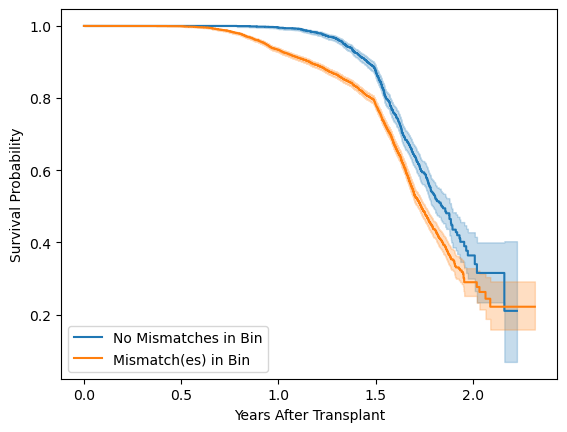

In [15]:
for i in range(1, 7):
    for j in range(1, 10, 2):
        bin_feature_matrix, amino_acid_bins, \
                amino_acid_bin_scores, maf_0_features = experiment(
            mm_frequency_range=(i/10, (i+2)/10) , 
            censoring_frequency=j/10, 
            exp_str="MM Freq Range=" + str((i/10, (i+2)/10)) + ", Censoring Freq="+str(j/10)
        )
        score_df(amino_acid_bin_scores, amino_acid_bins)
        top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                               amino_acid_bin_scores)